In [59]:
# Lab 6 
# Mohammed Mohideen

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchsummary import summary


In [145]:
# The MNIST is a dataset that contains handwritten digits which is used for training and evaluating image classification models
# The dataset contains 60,000 training images and 10,000 test images. There are 10 classes for each digit from 0 to 9.
# Each image is 28x28 pixels with a single channel

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [149]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [151]:
# Load MNIST dataset

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

In [153]:
# Split train dataset into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [155]:
# Create DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)



In [179]:
# Define CNN
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [181]:
# Instantiate model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [183]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Linear-6                  [-1, 128]       1,605,760
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.25
Params size (MB): 6.20
Estimated Total Size (MB): 7.45
---------------------------------------

In [185]:
num_epochs = 50  

train_losses = []
val_losses = []
test_losses = []
train_acc = []
val_acc = []
test_acc = []


In [187]:
for epoch in range(num_epochs):

    # Training phase
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_acc.append(correct / total)

    # Evaluate on test set
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_acc.append(correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Validation Acc: {val_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}')


Epoch [1/50], Train Loss: 0.1889, Validation Loss: 0.0607, Test Loss: 0.0515, Train Acc: 0.9429, Validation Acc: 0.9811, Test Acc: 0.9835
Epoch [2/50], Train Loss: 0.0770, Validation Loss: 0.0462, Test Loss: 0.0414, Train Acc: 0.9766, Validation Acc: 0.9875, Test Acc: 0.9866
Epoch [3/50], Train Loss: 0.0575, Validation Loss: 0.0441, Test Loss: 0.0386, Train Acc: 0.9828, Validation Acc: 0.9877, Test Acc: 0.9880
Epoch [4/50], Train Loss: 0.0447, Validation Loss: 0.0447, Test Loss: 0.0351, Train Acc: 0.9862, Validation Acc: 0.9869, Test Acc: 0.9896
Epoch [5/50], Train Loss: 0.0375, Validation Loss: 0.0497, Test Loss: 0.0350, Train Acc: 0.9885, Validation Acc: 0.9890, Test Acc: 0.9907
Epoch [6/50], Train Loss: 0.0294, Validation Loss: 0.0430, Test Loss: 0.0321, Train Acc: 0.9903, Validation Acc: 0.9892, Test Acc: 0.9906
Epoch [7/50], Train Loss: 0.0287, Validation Loss: 0.0450, Test Loss: 0.0321, Train Acc: 0.9908, Validation Acc: 0.9898, Test Acc: 0.9919
Epoch [8/50], Train Loss: 0.0236, 

In [189]:
# Save the model

torch.save(model.state_dict(), 'mnist_cnn.pth')

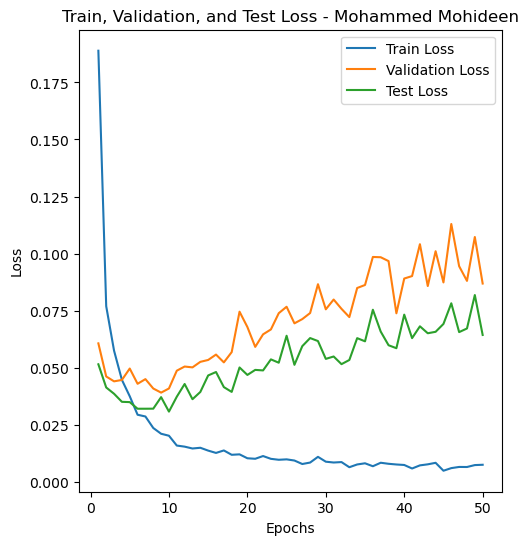

In [192]:
epochs_range = range(1, num_epochs + 1)

# Plot Train, Validation, and Test Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train, Validation, and Test Loss - Mohammed Mohideen')
plt.legend()

In [200]:
# it seems as the training loss decreases way more than the test and validation loss
# one possible reason for this can be overfitting

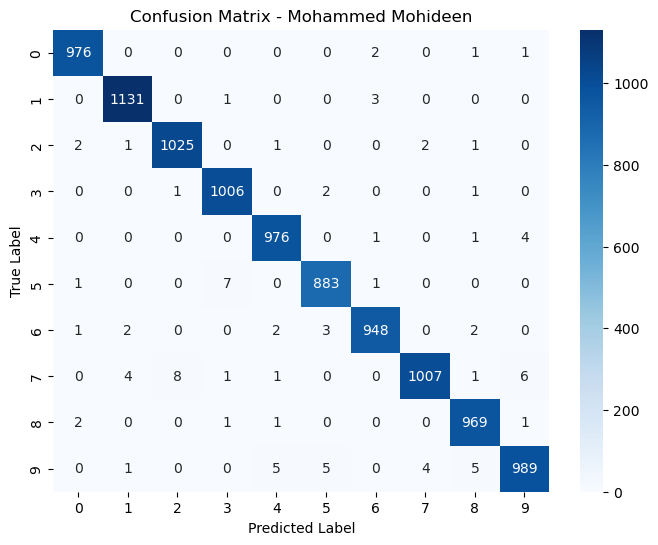

In [194]:
# Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Mohammed Mohideen')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
# A majority of the numbers were guessed properly. The digit that was the least guessed was 5. This might be because it resembles the other digits the most

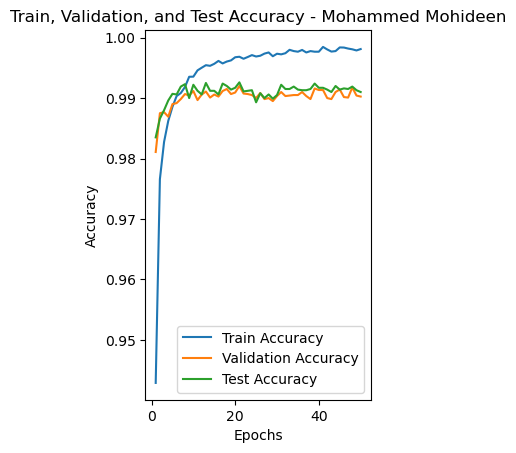

In [196]:
# Training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train, Validation, and Test Accuracy - Mohammed Mohideen')
plt.legend()


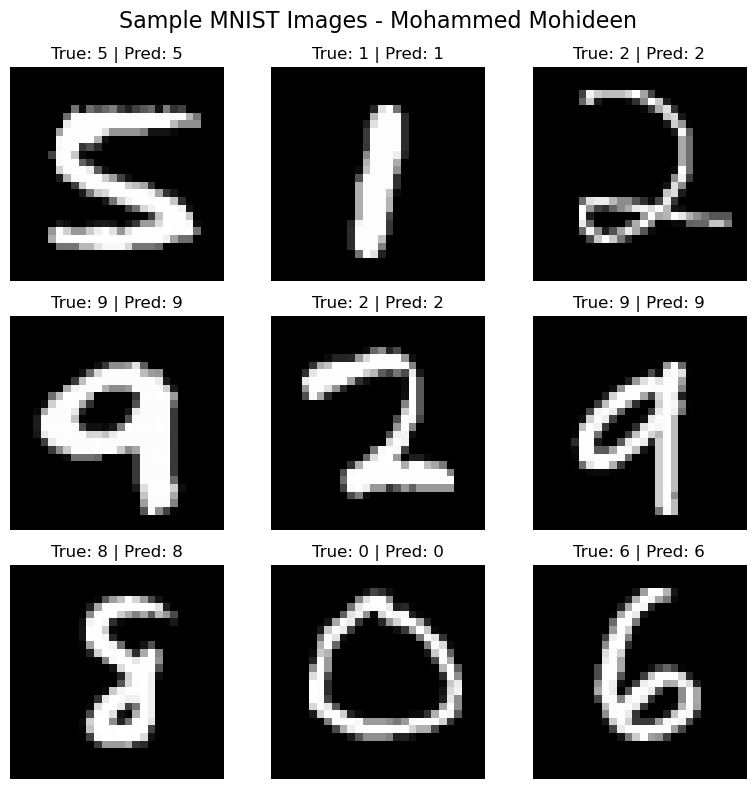

In [208]:

train_loader = DataLoader(dataset=train_dataset, batch_size=9, shuffle=True)
model.eval()

# Get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Move images to device
images = images.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Get the predicted label

# Move data back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Set up the grid of images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
plt.suptitle('Sample MNIST Images - Mohammed Mohideen', fontsize=16)

# Display the images with predictions
for i in range(9):
    img = images[i].numpy().squeeze()  # Remove the channel dimension
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {labels[i].item()} | Pred: {predicted[i].item()}')
    axes[i].axis('off')  

plt.tight_layout()
plt.show()